# Adaptive Stochastic Shortest Paths
In this notebook the adaptive shortest path problem from Section 5.6 is illustrated with an example. In this example, we first set up a graph that we extract from an actual road network. The example will be to find the fastest way from Karlsruhe main station to Hochschule Karlsruhe by car.

Solving a deterministic shortest path problem corresponds to finding the fastest way of getting from a source to a destination using nominal (expected) travel times and can be done efficiently using, e.g. Dijkstra's algorithm (which uses ideas from dynamic programming). 

We will then impose a (fictional) stochastic model on the graph. While traversing the graph only the costs of the immediate links is revealed. Subsequent costs must be learned and are reflected in a value function approximation.

To run this notebook, you need to install the packages `osmnx` and `networkx` that you can install by running `pip install osmnx` in a terminal. `osmnx` provides access to open street maps data and models the data as graphs using the Python package `networkx`.

## Graph setup and deterministic shortest path
We start by downloading a 4x4 km area of central Karlsruhe from open street maps. 

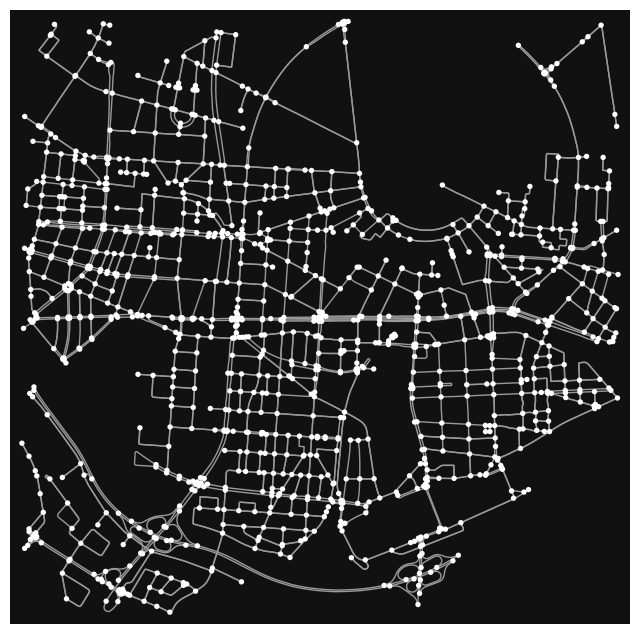

The graph consists of 1140 nodes and 2594 edges.


In [1]:
import osmnx as ox
import networkx as nx
import numpy as np

# Coordinates of Kriegsstr./Karlstr. intersection
point = 49.005433, 8.394618

# Get data from open street maps and plot network
G = ox.graph_from_point(point, dist=2000, network_type="drive", simplify=True)
fig, ax = ox.plot_graph(G)

# impute missing edge speeds then calculate edge travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

print(f"The graph consists of {len(G.nodes)} nodes and {len(G.edges)} edges.")

Next, we set our origin and destination nodes for the example:
- origin: Karlsruhe Hbf
- destination: Hochschule Karlsruhe, E-Building

In [2]:
# get the nearest network nodes to two points
orig = ox.distance.nearest_nodes(G, Y=48.994666, X=8.401867) # Karlsruhe Hbf
dest = ox.distance.nearest_nodes(G, Y=49.015000, X=8.390525) # HKA, E-Building

We compute the deterministic shortest path between origin and destination using the `shortest_path` method from `networkx`. By default, it uses Dijkstra's algorithm (a kind of dynamic programming).

The path consists of 35 edges:

{'osmid': 25450407, 'lanes': '2', 'name': 'Bahnhofplatz', 'highway': 'residential', 'maxspeed': '30', 'oneway': False, 'reversed': False, 'length': 23.999000000000002, 'geometry': <LINESTRING (8.402 48.995, 8.402 48.995, 8.402 48.995)>, 'speed_kph': 30.0, 'travel_time': 2.9}
{'osmid': [421292377, 146037684, 534883547, 473908132], 'name': 'Bahnhofplatz', 'highway': 'residential', 'maxspeed': '30', 'access': 'no', 'width': ['8.8', '10.6', '9.7'], 'oneway': False, 'reversed': [False, True], 'length': 118.53999999999999, 'geometry': <LINESTRING (8.402 48.995, 8.402 48.995, 8.402 48.995, 8.401 48.995, 8.401 4...>, 'speed_kph': 30.0, 'travel_time': 14.2}
{'osmid': [25870510, 398889303, 398889304, 398889305, 398889306], 'lanes': '2', 'name': 'Bahnhofplatz', 'highway': 'tertiary', 'maxspeed': '30', 'oneway': False, 'reversed': True, 'length': 76.24000000000002, 'geometry': <LINESTRING (8.4 48.995, 8.4 48.995, 8.4 48.995, 8.4 48.995, 8.4 48.995, 8.4...>, 'speed_k

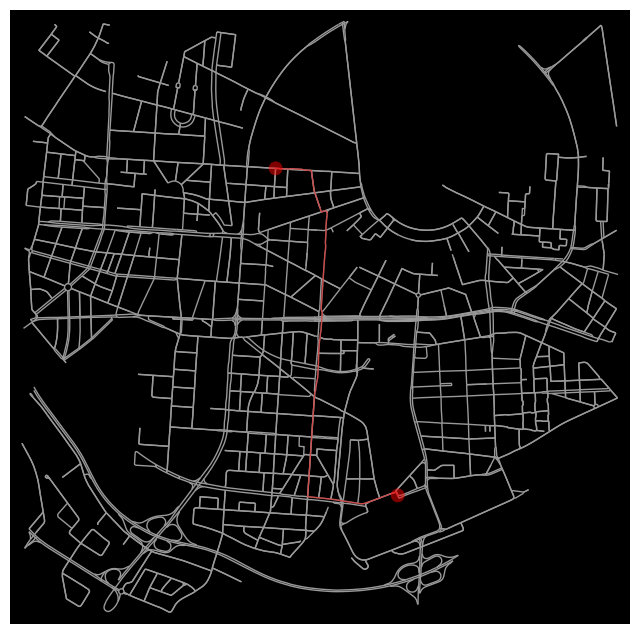

In [3]:
shortest_path = nx.shortest_path(G, orig, dest, weight="travel_time")
shortest_path_length = 0.0

print(f"The path consists of {len(shortest_path)} edges:\n")
for e in zip(shortest_path, shortest_path[1:]):
    print(G.edges[e+(0,)])
    shortest_path_length += G.edges[e+(0,)]["travel_time"]
print(f"\nThe travel time is {shortest_path_length} seconds.")

# Visualize shortest path
fig, ax = ox.plot_graph_route(G, shortest_path, route_linewidth=1, node_size=0, bgcolor='k')

## Stochastic problem

We now construct an adaptive stochastic shortest path problem. Remember that the true costs of an edge are only revealed when we are at a node adjacent to that edge. The policy how the traveller chooses the next node is to select the one which minimizes the sum of the costs of the next edge (this is the information that was just revealed) plus the value of the next node, i.e., the expected length of the shortest path from the next node to the destination. This value will be an approximation, which we will have to *learn*. In summary, when at a node $i$, the traveller determines the next node by

$$
x_t(i) = \argmin_{j \in \mathcal{N}_i^+}(\hat{c}_{tij}+\overline{V}^x_t(j)).
$$

We use another index, the superscript $n$, to denote the approximation of the value function $\overline{V}^x_t(j)$ after $n$ samples: $\overline{V}^{x,n}_t(j)$. We need an initial approximation $\overline{V}^{x,0}_t(j)$ to start with. We choose this bases on the deterministic shortest path problem. For this, we let Dijkstra's algorithm run backwards from the destination to *all* nodes. The length of the shortest path then becomes the initial value $\overline{V}^{x,0}_t(j)$ for any node $j$. Nodes that cannot be reached are given the value $\infty$.

Next we need a stochastic model to model the actual travel times. In reality, one could use historic data, as the statistics within the graph are hard to model (think of interdependencies regarding traffic between nearby edges / road segments). Here we choose a somewhat contrived example instead. To illustrate the difference between the policy based on the value function of the deterministic shortest path and a learned value function we model the travel time of every edge randomly but *independent of the edge length and the allowed speed* (unrealistic, but serves the purpose of showing how a value function is learned).

In [16]:
import SSPStaticModel
import SSPStaticPolicy

import importlib
importlib.reload(SSPStaticModel)
importlib.reload(SSPStaticPolicy)

m = SSPStaticModel.SSPStatic(G=G, origin=orig, destination=dest)
pol = SSPStaticPolicy.SSPStaticPolicy(model=m, theta_step=100)

We now have created a model and a policy that for now is based on the initial (unlearned) value function approximation. We run the policy one thousand times to calculate the expected travel time.

In [17]:
print(f"Expected travel time: {pol.run_policy(1000)} seconds.")

Expected travel time: 195.70529579802263 seconds.


We have a closer look on those routes. We determine the number of different routes that were found during the 1000 runs and plot a random subset of 6 of them on the map.

There were 37 different routes used by the policy.


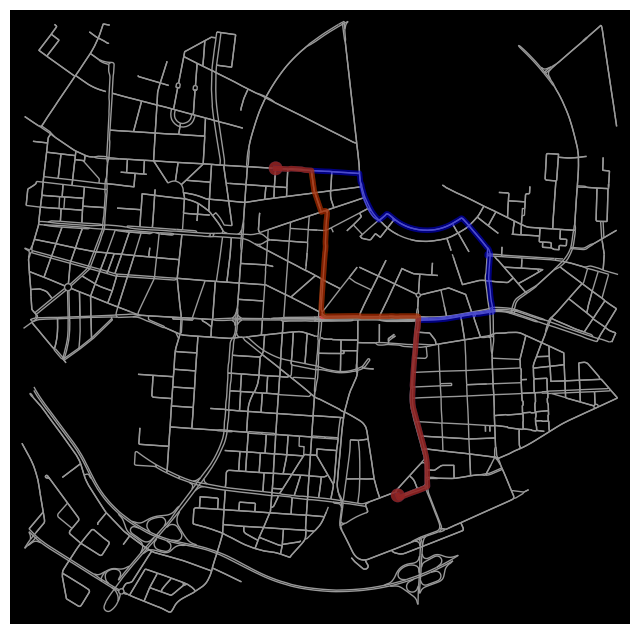

In [18]:
def evaluate_routes(pol):

    routes = []
    len_routes = []

    # Retrieve all different routes
    for N in range(pol.results.N.max()+1):
        route = list(pol.results.loc[pol.results.N==N,"CurrentNode"])
        if route not in routes and len(route) < 300:
            routes.append(route)
            len_routes.append(len(route))

    print(f"There were {len(routes)} different routes used by the policy.")
    route = list(pol.results.loc[pol.results.N==10,"CurrentNode"])

    # Plot a sample of 6 different routes
    if len(routes) > 6:
        routes_idx = np.random.choice(len(routes), size=3, replace=False)
        routes_sample = []
        for i in routes_idx:
            routes_sample.append(routes[i-1])
    elif len(routes) == 1:
        routes_sample = routes + routes
    else:
        routes_sample = routes
        
    # Route colors 
    route_colors = ["b", "g", "r", "c", "m", "y"]
    route_colors = route_colors[:len(routes_sample)]

    fig, ax = ox.plot_graph_routes(G, routes_sample, route_linewidth=1, node_size=0, route_colors=route_colors, bgcolor='k')

evaluate_routes(pol)

We see that the algorithm finds different routes depending on the (random) costs observed plus the value of the subsequent node (fixed). Note that they also differ from the deterministic shortest path solution because the value function from the deterministic problem is only one summand in the policy. 

Next, we train the model, which means we create samples to find a better approximation of the value function.

In [19]:
V_t_origin = pol.train_value_function(1000)

Afterwards, we simulate the policy again one thousand times to get the expected length based on the new value function.

In [20]:
print(f"Expected travel time: {pol.run_policy(1000)} seconds.")

Expected travel time: 195.66158885673613 seconds.


The expected travel time reduced by about 25% because we now have a better approximation of the value function which in turn allows us to make better decisions. Let's look at some of those paths. 

There were 34 different routes used by the policy.


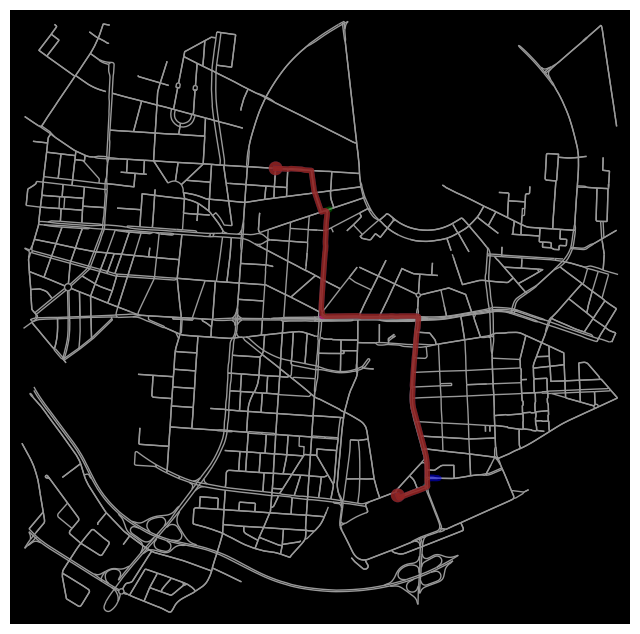

In [21]:
evaluate_routes(pol)

Note that the paths are all very similar. Because we set the random process up such that every edge has the same expected travel time (independent of length) the policy decides that it is beneficial to always take a path with a *small number of edges*. This is learned by the value function and is reflected in the displayed paths.

In this example, learning of the value function went quite smoothly. In general, learning the value function of a problem is often a tedious task with many parameters to tune and high computational effort.